<a href="https://colab.research.google.com/github/Tessellate-Imaging/Monk_Object_Detection/blob/master/example_notebooks/3_mxrcnn/Example%20-%20playing%20card%20detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

 - Run these commands
     
     - git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git
     
     - cd Monk_Object_Detection/3_mxrcnn/installation
     
 - Select the right requirements file and run
 
     - cat requirements_cuda9.0.txt | xargs -n 1 -L 1 pip install

In [ ]:
! git clone https://github.com/Tessellate-Imaging/Monk_Object_Detection.git

In [ ]:
# For colab use the command below
! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_colab.txt | xargs -n 1 -L 1 pip install


# For Local systems and cloud select the right CUDA version
#! cd Monk_Object_Detection/3_mxrcnn/installation && cat requirements_cuda9.0.txt | xargs -n 1 -L 1 pip install

# Download Dataset

- credits: https://www.kaggle.com/luantm/playing-card

- Install kaggle client using: https://github.com/Kaggle/kaggle-api
    - CMD: `pip install -U kaggle`
    

In [1]:
! kaggle datasets download -d luantm/playing-card -q

In [2]:
! unzip -qq playing-card.zip

# VOC Format

## Dataset Directory Structure (Non-Standard)

      card_dataset     (root_dir)
          |
          |-----------Images+Annotations (img_dir + anno_dir)
          |              |
          |              |------------------img1.jpg
          |              |------------------img1.xml
          |              |------------------img2.jpg
          |              |------------------img2.xml
          |              |------------------.........(and so on)
        

# Desired annotation - COCO Format

## Dataset Directory Structure

    ./ (root_dir)
          |
          |------card_dataset (coco_dir) 
          |         |
          |         |---Images (img_dir)
          |         |----|
          |              |-------------------img1.jpg
          |              |-------------------img2.jpg
          |              |-------------------.........(and so on)
          |
          |
          |         |---annotations (anno_dir)
          |         |----|
          |              |--------------------instances_Images.json 
          |              |--------------------classes.txt
          
          
 - instances_Train.json -> In proper COCO format
 - classes.txt          -> A list of classes in alphabetical order

# Annotation Conversion - Step 1 - VOC to Monk format

In [3]:
import os
import sys
import numpy as np
import pandas as pd

import xmltodict
import json
from tqdm.notebook import tqdm

from pycocotools.coco import COCO

In [6]:
root_dir = "card_dataset/";
img_dir = "train/";
anno_dir = "train/";

In [8]:
files_tmp = os.listdir(root_dir + anno_dir);
files = [];
for i in range(len(files_tmp)):
    ext = files_tmp[i].split(".")[-1];
    if(ext == "xml"):
        files.append(files_tmp[i])

In [9]:
combined = [];
for i in tqdm(range(len(files))):
    annoFile = root_dir + "/" + anno_dir + "/" + files[i];
    f = open(annoFile, 'r');
    my_xml = f.read();
    anno = dict(dict(xmltodict.parse(my_xml))["annotation"])
    fname = anno["filename"];
    label_str = "";
    if(type(anno["object"]) == list):
        for j in range(len(anno["object"])):
            obj = dict(anno["object"][j]);
            label = anno["object"][j]["name"];
            bbox = dict(anno["object"][j]["bndbox"])
            x1 = bbox["xmin"];
            y1 = bbox["ymin"];
            x2 = bbox["xmax"];
            y2 = bbox["ymax"];
            if(j == len(anno["object"])-1):
                label_str += x1 + " " + y1 + " " + x2 + " " + y2 + " " + label;
            else:        
                label_str += x1 + " " + y1 + " " + x2 + " " + y2 + " " + label + " ";
    else:
        obj = dict(anno["object"]);
        label = anno["object"]["name"];
        bbox = dict(anno["object"]["bndbox"])
        x1 = bbox["xmin"];
        y1 = bbox["ymin"];
        x2 = bbox["xmax"];
        y2 = bbox["ymax"];
        
        label_str += x1 + " " + y1 + " " + x2 + " " + y2 + " " + label;
    
    
    combined.append([fname, label_str])

In [10]:
df = pd.DataFrame(combined, columns = ['ID', 'Label']);
df.to_csv(root_dir + "/train_labels.csv", index=False);

# Annotation Conversion - Step 1 - Monk format to COCO

In [11]:
import os
import numpy as np 
import cv2
import dicttoxml
import xml.etree.ElementTree as ET
from xml.dom.minidom import parseString
from tqdm import tqdm
import shutil
import json
import pandas as pd

In [12]:
# Provide details on directory in Monk Format

In [13]:
root = "card_dataset";
img_dir = "train/";
anno_file = "train_labels.csv";

In [14]:
# Need not change anything below

In [15]:
dataset_path = root;
images_folder = root + "/" + img_dir;
annotations_path = root + "/annotations/";

In [16]:
if not os.path.isdir(annotations_path):
    os.mkdir(annotations_path)
    
input_images_folder = images_folder;
input_annotations_path = root + "/" + anno_file;

In [17]:
output_dataset_path = root;
output_image_folder = input_images_folder;
output_annotation_folder = annotations_path;

tmp = img_dir.replace("/", "");
output_annotation_file = output_annotation_folder + "/instances_" + tmp + ".json";
output_classes_file = output_annotation_folder + "/classes.txt";

In [18]:
if not os.path.isdir(output_annotation_folder):
    os.mkdir(output_annotation_folder);

In [19]:
df = pd.read_csv(input_annotations_path);
columns = df.columns

In [20]:
delimiter = " ";

In [21]:
list_dict = [];
anno = [];
for i in range(len(df)):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    for j in range(len(tmp)//5):
        label = tmp[j*5+4];
        if(label not in anno):
            anno.append(label);
    anno = sorted(anno)
    
for i in tqdm(range(len(anno))):
    tmp = {};
    tmp["supercategory"] = "master";
    tmp["id"] = i;
    tmp["name"] = anno[i];
    list_dict.append(tmp);

anno_f = open(output_classes_file, 'w');
for i in range(len(anno)):
    anno_f.write(anno[i] + "\n");
anno_f.close();

100%|██████████| 6/6 [00:00<00:00, 14035.60it/s]


In [22]:
coco_data = {};
coco_data["type"] = "instances";
coco_data["images"] = [];
coco_data["annotations"] = [];
coco_data["categories"] = list_dict;
image_id = 0;
annotation_id = 0;


for i in tqdm(range(len(df))):
    img_name = df[columns[0]][i];
    labels = df[columns[1]][i];
    tmp = labels.split(delimiter);
    image_in_path = input_images_folder + "/" + img_name;
    img = cv2.imread(image_in_path, 1);
    h, w, c = img.shape;

    images_tmp = {};
    images_tmp["file_name"] = img_name;
    images_tmp["height"] = h;
    images_tmp["width"] = w;
    images_tmp["id"] = image_id;
    coco_data["images"].append(images_tmp);
    

    for j in range(len(tmp)//5):
        x1 = int(tmp[j*5+0]);
        y1 = int(tmp[j*5+1]);
        x2 = int(tmp[j*5+2]);
        y2 = int(tmp[j*5+3]);
        label = tmp[j*5+4];
        annotations_tmp = {};
        annotations_tmp["id"] = annotation_id;
        annotation_id += 1;
        annotations_tmp["image_id"] = image_id;
        annotations_tmp["segmentation"] = [];
        annotations_tmp["ignore"] = 0;
        annotations_tmp["area"] = (x2-x1)*(y2-y1);
        annotations_tmp["iscrowd"] = 0;
        annotations_tmp["bbox"] = [x1, y1, x2-x1, y2-y1];
        annotations_tmp["category_id"] = anno.index(label);

        coco_data["annotations"].append(annotations_tmp)
    image_id += 1;

outfile =  open(output_annotation_file, 'w');
json_str = json.dumps(coco_data, indent=4);
outfile.write(json_str);
outfile.close();

100%|██████████| 296/296 [00:01<00:00, 202.13it/s]


# Training

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/")
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/mx-rcnn")

In [2]:
from train_base import *

In [3]:
# Dataset params

In [4]:
root_dir = "./";
coco_dir = "card_dataset";
img_dir = "train"; 

In [5]:
set_dataset_params(root_dir=root_dir, 
                   coco_dir=coco_dir, imageset=img_dir);

In [6]:
# Model Type

In [7]:
set_model_params(model_name="vgg16");

In [8]:
# Hyper Params

In [9]:
set_hyper_params(gpus="0", lr=0.001, lr_decay_epoch="1", epochs=4, batch_size=1);

In [10]:
set_output_params(log_interval=100, save_prefix="model_vgg16");

In [11]:
# Preprocessing params

In [12]:
set_img_preproc_params(img_short_side=600, img_long_side=1000, 
                       mean=(123.68, 116.779, 103.939), std=(1.0, 1.0, 1.0));

In [13]:
# Initialize params

In [14]:
initialize_rpn_params();

In [15]:
initialize_rcnn_params();

In [16]:
# Remove caches if any

In [17]:
if os.path.isdir("./cache/"):
    os.system("rm -r ./cache/")

In [18]:
# Invoke Dataloader

In [19]:
roidb = set_dataset();

INFO:root:computing cache ./cache/coco_train_roidb.pkl
INFO:root:saving cache ./cache/coco_train_roidb.pkl
INFO:root:coco_train num_images 296
INFO:root:filter roidb: 296 -> 296
INFO:root:coco_train append flipped images to roidb


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [20]:
#Network

In [21]:
sym = set_network();

In [22]:
# Train

In [23]:
train(sym, roidb);

INFO:root:max input shape
{'bbox_target': (1, 36, 62, 62),
 'bbox_weight': (1, 36, 62, 62),
 'data': (1, 3, 1000, 1000),
 'gt_boxes': (1, 100, 5),
 'im_info': (1, 3),
 'label': (1, 1, 558, 62)}
INFO:root:max output shape
{'bbox_loss_reshape_output': (1, 128, 28),
 'blockgrad0_output': (1, 128),
 'cls_prob_reshape_output': (1, 128, 7),
 'rpn_bbox_loss_output': (1, 36, 62, 62),
 'rpn_cls_prob_output': (1, 2, 558, 62)}
INFO:root:locking params
['conv1_1_weight',
 'conv1_1_bias',
 'conv1_2_weight',
 'conv1_2_bias',
 'conv2_1_weight',
 'conv2_1_bias',
 'conv2_2_weight',
 'conv2_2_bias',
 'conv3_1_weight',
 'conv3_1_bias',
 'conv3_2_weight',
 'conv3_2_bias',
 'conv3_3_weight',
 'conv3_3_bias',
 'conv4_1_weight',
 'conv4_1_bias',
 'conv4_2_weight',
 'conv4_2_bias',
 'conv4_3_weight',
 'conv4_3_bias']
INFO:root:lr 0.001000 lr_epoch_diff [1] lr_iters [592]
INFO:root:Epoch[0] Batch [0-100]	Speed: 4.64 samples/sec	RPNAcc=0.947788	RPNLogLoss=0.172843	RPNL1Loss=0.802413	RCNNAcc=0.788598	RCNNLogLoss

# Running Inference

In [1]:
import os
import sys
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/")
sys.path.append("Monk_Object_Detection/3_mxrcnn/lib/mx-rcnn")

In [2]:
from infer_base import *

In [3]:
class_file = set_class_list("./card_dataset/annotations/classes.txt");

In [4]:
#Model - Select the model as per number of iterations it has been trained for

In [5]:
set_model_params(model_name="vgg16", model_path="trained_model/model_vgg16-0004.params");

In [6]:
#Hyper Params

In [7]:
set_hyper_params(gpus="0", batch_size=1);

In [8]:
# Preprocessing

In [9]:
set_img_preproc_params(img_short_side=600, img_long_side=1000, 
                       mean=(123.68, 116.779, 103.939), std=(1.0, 1.0, 1.0));

In [10]:
#Initalization

In [11]:
initialize_rpn_params();

In [12]:
initialize_rcnn_params();

In [13]:
#Network

In [14]:
sym = set_network();
mod = load_model(sym);

In [15]:
#Load Image and infer

ace
 0.9597503542900085 [148.3417018999005, 83.90620404263191, 382.8754715625595, 492.99056336055]
ace
 0.5799654722213745 [59.18078618306434, 109.41343975745646, 129.82747940786615, 437.7891236174623]
['ace\n', 0.9597503542900085, [148.3417018999005, 83.90620404263191, 382.8754715625595, 492.99056336055]]


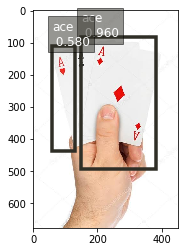

In [39]:
set_output_params(vis_thresh=0.55, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/card_test/img3.jpeg", mod);

ace
 0.9895508885383606 [196.94495849609376, 292.27158203125, 431.86494140625, 473.400048828125]
['ace\n', 0.9895508885383606, [196.94495849609376, 292.27158203125, 431.86494140625, 473.400048828125]]


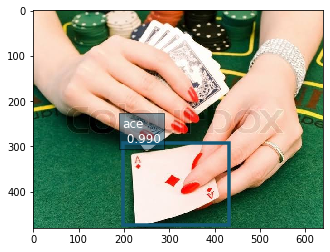

In [42]:
set_output_params(vis_thresh=0.9, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/card_test/img5.jpeg", mod);

ace
 0.9289224147796631 [23.672652995008743, 216.86185814360186, 159.01728191825262, 331.73778724091596]
ace
 0.7662843465805054 [312.3098840312007, 231.7871012093419, 422.2544472536303, 328.6251831889669]
ace
 0.5554117560386658 [446.8487556346718, 215.41299718352187, 556.4316610358804, 316.7091683251694]
nine
 0.7482169270515442 [180.59866849399623, 224.7483319224843, 277.5690895792069, 324.0098681426535]
['ace\n', 0.9289224147796631, [23.672652995008743, 216.86185814360186, 159.01728191825262, 331.73778724091596]]


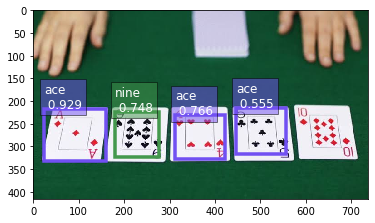

In [54]:
set_output_params(vis_thresh=0.55, vis=True)
Infer("Monk_Object_Detection/example_notebooks/sample_dataset/card_test/img11.jpeg", mod);